In [5]:
## All necessary imports
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.feature as cfeature
from matplotlib import cm, colors, ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.collections import PolyCollection
import matplotlib
from matplotlib import ticker
import numpy as np
from Plot_2D import Plot_2D
import cartopy.crs as crs
import cmaps
import pandas as pd
import matplotlib.lines as mlines
from scipy.stats import gaussian_kde
from scipy import stats
import mpl_scatter_density
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [157]:
## Functions used to produce the colocated flat files and scatter plots

## Get nearest ncol
def get_nearestlatlon(lon1,lat1,lon,lat):
    ind=np.argmin((lon1.values-lon)**2+(lat1.values-lat)**2)
    return ind

## Get IMPROVE and ncol data
def get_IMPROVE_sites(res='ne30pg2',reg='NA'):
    improve = xr.open_dataset('aerosol_IMPROVE.nc')
    lon1=improve['siteloc'][:,0].astype('float32').values
    lat1=improve['siteloc'][:,1].astype('float32').values
    ## dict of lat/lon range for different regions
    start = {'NA':-50,'EUS':-50,'NEUS':-50,'WUS':-120,'midwest':-98}
    end = {'NA':-170,'EUS':-98,'NEUS':-80,'WUS':-170,'midwest':-115}
    regions = ['NA','EUS','NEUS','WUS','midwest']
    ## Get all site locations within NA
    lon_na=[]
    lat_na=[]
    site_names=[]
    site_number=[]
    for item,site,name in zip(improve['siteloc'],improve['site'],improve['sitecode']):
        lon,lat=item.values
        if (lat>=17) and (lat<=77) and (lon<=start[reg]) and (lon>=end[reg]):
            lon_na.append(lon.astype('float32'))
            lat_na.append(lat.astype('float32'))
            site_names.append(str(name.values.astype(str)))
            site_number.append(improve['site'][lon1==lon].values[0])
    ## getting the ncol nearest to the IMPROVE data locs
    if res=='ne30pg2':
        path='/compyfs/hass877/e3sm_scratch/F20TR_v2_ndg_ERA5_SEdata/run/' # ne30pg2
        forinds=xr.open_dataset('total_so2_2014_surf_625_384x576_ne30pg2.nc')
    else:
        path='/compyfs/hass877/e3sm_scratch/F20TR_v2_ndg_ERA5_SEdata_NA_RRM_CDT/run/' # RRM
        forinds=xr.open_dataset('total_bc_2014_lowres_96x144_northamericax4v1pg2.nc')
    #forinds=xr.open_mfdataset('*eam.h0.2016-01*')
    lon2=forinds.lon
    lon2[lon2 > 180.] -= 360.
    lat2=forinds.lat
    aerind=[]
    for lon,lat in zip(lon_na,lat_na):
        ii=get_nearestlatlon(lon2,lat2,lon,lat)
        aerind.append(ii)
    df = pd.DataFrame()
    df['site'] = site_number
    df['sitename'] = site_names
    df['lats'] = lat_na
    df['lons'] = lon_na
    df['ncols'] = aerind
    return df, improve['conc'][site_number]

## Get IMPROVE conc data
def get_data(data,aer,temp='month'):
    data = data[:,aer,1]
    if temp=='month':
        data = data.mean('day')
    elif temp=='annual':
        data = data.mean(['day','month'])
    
    print('Mean: ',data.mean().values)
    print('STD: ',data.std().values)
    print('Min: ',data.min().values,'\nMax: ',data.max().values)
    return data

## Get Scatter plots
def get_scatter_plot(df_nona,v,res,ax,treatment='Default',temp='daily',size=1,cax=None,maxv=None,vv='aerosol Conc.'):
    var = v+'_'+res
    df_nona = df_nona[df_nona[var].notna()].reset_index(drop=True)
    # Calculate the point density
    corr=stats.pearsonr(df_nona['obs'],df_nona[var])
    xy = np.vstack([df_nona['obs'],df_nona[var]])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    improve_obs, mod, z_mod = df_nona['obs'][idx], df_nona[var][idx], z[idx]
    if maxv==None:
        maxv = z_mod.max()
    #improve_obs, mod, z_mod = density_scatter(df['obs'], df['mod'])
    RMSE=np.sqrt(np.divide(np.sum(np.multiply((df_nona[var]-df_nona['obs']),(df_nona[var]-df_nona['obs']))),len(df_nona['obs'])))
    heatmap = ax.scatter(improve_obs, mod, c=z_mod, s=size, edgecolor='k',cmap=plt.cm.plasma_r,vmax=maxv, vmin=0,zorder=2)
    plt.grid(linestyle='--',color='#EBE7E0',zorder=1)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.text(0.005,1.03,treatment+' treatment | '+res,size=15,transform=ax.transAxes)
    ax.text(0.05,0.9,'R: '+str(np.round(corr[0],3)),size=15,transform=ax.transAxes)
    ax.text(0.05,0.82,'RMSE: '+str(np.round(RMSE,3)),size=15,transform=ax.transAxes)
    plt.colorbar(heatmap)
    plt.setp(ax.spines.values(),lw=1.5)
    if cax==None:
        if 'bc' in v:
            xx1=4e-4 # BC
            yy1=1e-3 # BC
        elif 'so4' in v:
            xx1=1e-2 # SO4
            yy1=1e-1 # SO4
        elif 'pom' in v:
            xx1=1e-2 # SO4
            yy1=1e-2 # SO4
        xx2=1e1
        yy2=1e1 # BC
    else:
        xx1,yy1,xx2,yy2=cax
    plt.xlim([xx1,xx2]) # BC
    plt.ylim([yy1,yy2]) #BC
    ###########
    x1 = mlines.Line2D([xx1, xx2], [yy1, yy2], color='k', linestyle='-',linewidth=1)
    ax.add_line(x1)
    x1 = mlines.Line2D([2*xx1, xx2], [yy1, 0.5*yy2], color='k', linestyle='--',linewidth=1)
    ax.add_line(x1)
    x1 = mlines.Line2D([xx1, 0.5*xx2], [2*yy1, yy2], color='k', linestyle='--',linewidth=1)
    ax.add_line(x1)
    ax.tick_params(labelsize=12)
    plt.ylabel(vv,fontsize=15)
    plt.xlabel('Observation ($\u03BCg\ m^{-3}$)',fontsize=15)
    
## Get data with improved biases
def get_improved_sites(df_nona,varbs,v,res,np=25):
    ## Separate sites based on bias
    for var in varbs:
        df_nona[var+'_bias_'+res]=df_nona[var+'_'+res]-df_nona['obs']
    ## Get the improved and degraded sites
    improved_sites = df_nona[df_nona['SE_'+v+'_bias_'+res]<df_nona[v+'_bias_'+res]]
    degraded_sites = df_nona[df_nona['SE_'+v+'_bias_'+res]>df_nona[v+'_bias_'+res]]
    input=0
    best = improved_sites.iloc[(improved_sites['SE_'+v+'_bias_'+res]-input).abs().argsort()[:np]]
    return improved_sites,degraded_sites,best

## Get emission differences over IMPROVE sites
def get_emis_data(df,res,var):
    vals=df['ncols_'+res].values
    emis_diff = xr.open_dataset(var+'_emission_diff_'+res+'.nc')
    df['emis_diff_'+res]=emis_diff['diff'][vals].values
    emis_rel = xr.open_dataset(var+'_emission_rel_'+res+'.nc')
    df['emis_rel_'+res]=emis_rel['rel'][vals].values
    return df

## Mask data based on emissions
def get_emisMasked(df,res,stat='diff',factor=1,pos=None,neg=None):
    if pos==None:
        pos=df['emis_'+stat+'_'+res].mean()+factor*df['emis_'+stat+'_'+res].std()
    if neg==None:
        neg=df['emis_'+stat+'_'+res].mean()-factor*df['emis_'+stat+'_'+res].std()
    df1=df[(df['emis_'+stat+'_'+res]<=neg)] 
    df2=df[(df['emis_'+stat+'_'+res]>=pos)]
    df=pd.concat([df1,df2])
    print(df['emis_'+stat+'_'+res].mean(),df['emis_'+stat+'_'+res].std())
    return df

## Scatter plots of colocated model data with observation

Comparing the model simulated surface concentrations with IMPROVE data set. Since IMPROVE provides only the fine mode aerosol concentrations, mode 3 is not estimated in the total concentration calculations (e.g., total BC = bc_a1 + bc_a4). 

Colocated daily data are saved in csv files. These flat files contain daily concentrations from models (from both ne30pg2 and RRM resolutions), observations, observation site locations (i.e., in terms of "ncol" number), biases, emissions absolute and relative differences on those sites.

In [19]:
## Example header
df = pd.read_csv('BC_IMPROVE_dailydata.csv')
df.head()

,Unnamed: 0,time,ncol,bc_a1_SRF,bc_a1_SRF_ne30pg2,SE_bc_a1_SRF_ne30pg2,bc_a4_SRF_ne30pg2,SE_bc_a4_SRF_ne30pg2,bc_a3_SRF_ne30pg2,SE_bc_a3_SRF_ne30pg2,...,SE_bc_a3_SRF_RRM,bc_RRM,SE_bc_RRM,ncols_ne30pg2,ncols_RRM,emis_diff_ne30pg2,emis_rel_ne30pg2,emis_diff_RRM,emis_rel_RRM,obs
0,2016-01-01,2016-01-01,0,0.021501,0.021501,0.021886,0.158604,0.153155,0.000499,0.000530,...,0.001056,0.155735,0.131123,18961,40043,0.033782,11.150569,-0.189490,-60.430825,0.11758
1,2016-01-01,2016-01-01,1,0.075640,0.075640,0.081201,0.205207,0.258455,0.000122,0.000152,...,0.000244,0.183170,0.122544,14061,33260,1.469470,71.923640,-0.265085,-15.323989,NaN
2,2016-01-01,2016-01-01,2,0.082331,0.082331,0.085022,0.198266,0.236205,0.003932,0.004347,...,0.005824,0.266510,0.421384,13985,34471,0.720764,75.465497,2.441868,278.747606,0.44221
3,2016-01-01,2016-01-01,3,0.028705,0.028705,0.028892,0.028740,0.034160,0.000292,0.000214,...,0.000259,0.090849,0.099230,14326,36929,0.007238,5.573179,0.034565,26.776282,0.10930
4,2016-01-01,2016-01-01,4,0.013636,0.013636,0.012585,0.052329,0.076085,0.000095,0.000078,...,0.000244,0.056757,0.033658,20529,51047,0.430760,118.544202,-0.221372,-52.650277,NaN


### Plotting scatters for BC

These scatter plots essentially show the spatial distribution correlations. Considering the IMPROVE sites that show significantly larger emissions differences. For this purpose, we can choose a threshhold based on either the absoulte or relative difference. For this case, I chose the sites that falls beyond "mean +/- 1/2*standard deviation". 

**Why 1/2 STD?**


(1) Choice of 1*STD shows similar results, but the number of data points become smaller (which is important for statistical significance). We also have to choose a threshold such that the sites beyond that are sites that falls within the high gradient region. That is where we expect to see the largest improvements. 

(2) Choice of a threshold relative difference also shows improved spatial correlations. In this case, the threshold relative difference can be different for different species (so that to occupy the sites with high gradient regions). For instance, BC with 50% threshold (sites with BC emissions relative difference +50% and below -50%), monthly scatter plot produces corr of 0.455 and 0.512 for deafault and new treatment respectively.

**Updated with 25th or 75th percentile**

0.4849895522383633 0.8555184532017265


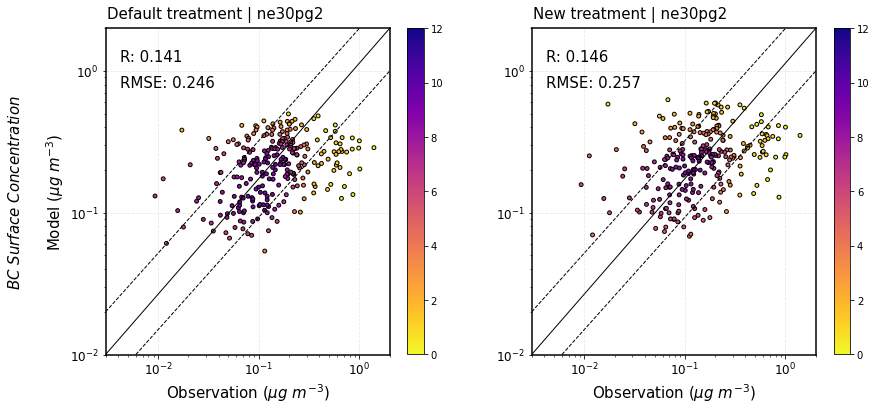

In [162]:
## All available sites with emission mask
varbs = ['bc_a1_SRF','SE_bc_a1_SRF','bc_a4_SRF','SE_bc_a4_SRF','bc','SE_bc']
df = pd.read_csv('BC_IMPROVE_dailydata.csv')
variable='BC'
df.index=pd.to_datetime(df['time'])
## Get rid of nans & -ve vals
df_nona = df[df['obs'].notna()]
df_nona = df_nona[df_nona['obs']>0]
res='ne30pg2'
## Masking data based on mean +/- 0.5*Standard deviation
df_nona=get_emisMasked(df_nona,res,stat='diff',factor=0.68)
## Estimating the monthly and annual averages from daily data
df_monthly = df_nona.groupby('ncols_'+res).resample('1M').mean()
df_annual = df_nona.groupby('ncols_'+res).resample('1Y').mean()
## Plotting
plt.figure(figsize=(14,6))
i=1
for v,treat,ylab in zip(varbs[-2:],['Default','New'],['$'+variable+'\ Surface\ Concentration$ \n\nModel ($\u03BCg\ m^{-3}$)','']):
    ax=plt.subplot(1,2,i)
    get_scatter_plot(df_monthly,v,res,ax,treatment=treat,temp='monthly',size=15,cax=[3e-3,1e-2,2e0,2e0],maxv=12,vv=ylab)
    i+=1


0.8932794619899266 1.7793017626844343


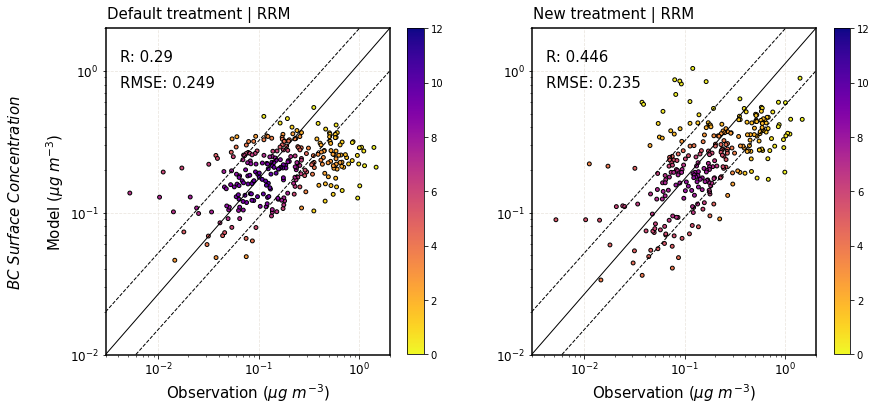

In [159]:
## All available sites with emission mask
varbs = ['bc_a1_SRF','SE_bc_a1_SRF','bc_a4_SRF','SE_bc_a4_SRF','bc','SE_bc']
df = pd.read_csv('BC_IMPROVE_dailydata.csv')
variable='BC'
df.index=pd.to_datetime(df['time'])
## Get rid of nans & -ve vals
df_nona = df[df['obs'].notna()]
df_nona = df_nona[df_nona['obs']>0]
res='RRM'
## Masking data based on mean +/- 0.5*Standard deviation
df_nona=get_emisMasked(df_nona,res,stat='diff',factor=0.68)
## Estimating the monthly and annual averages from daily data
df_monthly = df_nona.groupby('ncols_'+res).resample('1M').mean()
df_annual = df_nona.groupby('ncols_'+res).resample('1Y').mean()
## Plotting
plt.figure(figsize=(14,6))
i=1
for v,treat,ylab in zip(varbs[-2:],['Default','New'],['$'+variable+'\ Surface\ Concentration$ \n\nModel ($\u03BCg\ m^{-3}$)','']):
    ax=plt.subplot(1,2,i)
    get_scatter_plot(df_monthly,v,res,ax,treatment=treat,temp='monthly',size=15,cax=[3e-3,1e-2,2e0,2e0],maxv=12,vv=ylab)
    i+=1


All correlations are based on monthly mean dataset. Using daily and annual mean data show similar results.

For ne30pg2, the correlation difference is insignificant. Since these scatter plots essentially indicate the spatial heterogeneity in surface concentration, we do not expect to see large improvements from low resolution scenarios. But, for RRM resolution, we see a significant improvement in correlations/heterogeneity in surface concentrations.

**How significant?**

We can estimate whether the 2 correlations are statistically significantly different based on Fisher's Z scores. For RRM, the correlations 0.352 and 0.505, with 336 data points, z-score is -2.4293 with a p-value of 0.0151. So, **the new treatment shows significant improvement over the default treatment** at 95% confidence level.

### Plotting scatters for POM

POM for RRM scenarios, also show significant improvements (z-score = -2.1868 and p-value = 0.0288).

2.9059262703584694 5.027095356795219


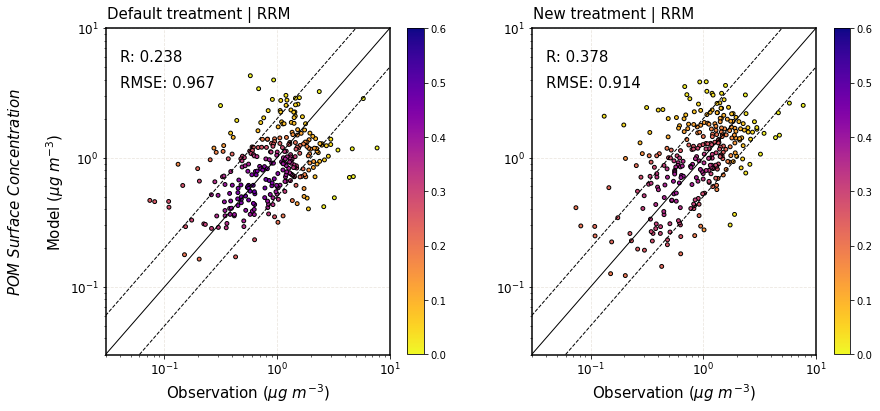

In [161]:
## All available sites with emission mask
varbs = ['pom_a1_SRF','SE_pom_a1_SRF','pom_a4_SRF','SE_pom_a4_SRF','pom','SE_pom']
df = pd.read_csv('POM_IMPROVE_dailydata.csv')
variable='POM'
df.index=pd.to_datetime(df['time'])
## Get rid of nans & -ve vals
df_nona = df[df['obs'].notna()]
df_nona = df_nona[df_nona['obs']>0]
res='RRM'
## Masking data based on mean +/- 0.5*Standard deviation
df_nona=get_emisMasked(df_nona,res,stat='diff',factor=0.68)
## Estimating the monthly and annual averages from daily data
df_monthly = df_nona.groupby('ncols_'+res).resample('1M').mean()
df_annual = df_nona.groupby('ncols_'+res).resample('1Y').mean()
## Plotting
plt.figure(figsize=(14,6))
i=1
for v,treat,ylab in zip(varbs[-2:],['Default','New'],['$'+variable+'\ Surface\ Concentration$ \n\nModel ($\u03BCg\ m^{-3}$)','']):
    ax=plt.subplot(1,2,i)
    get_scatter_plot(df_monthly,v,res,ax,treatment=treat,temp='monthly',size=15,cax=[3e-2,3e-2,1e1,1e1],maxv=0.6,vv=ylab)
    i+=1


### Plotting scatters for SO4

0.0026075429117066724 0.007259487458054354


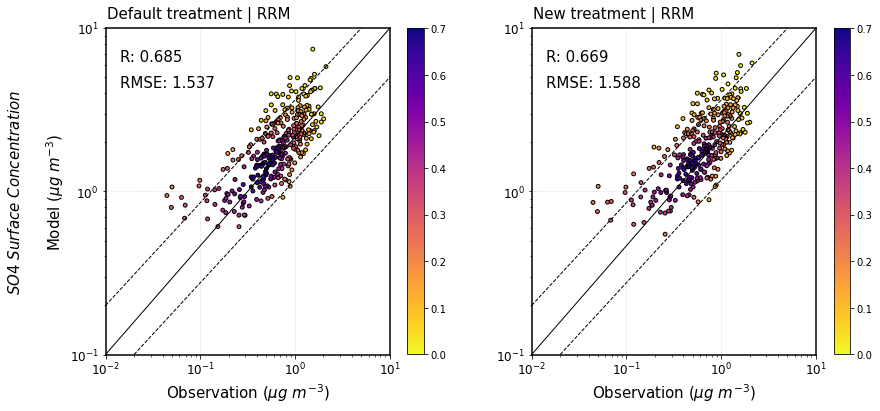

In [163]:
## All available sites with emission mask
varbs = ['so4_a1_SRF','SE_so4_a1_SRF','so4_a2_SRF','SE_so4_a2_SRF','so4','SE_so4']
df = pd.read_csv('SO4_IMPROVE_dailydata.csv')
variable='SO4'
df.index=pd.to_datetime(df['time'])
## Get rid of nans & -ve vals
df_nona = df[df['obs'].notna()]
df_nona = df_nona[df_nona['obs']>0]
res='RRM'
## Masking data based on mean +/- 0.5*Standard deviation
df_nona=get_emisMasked(df_nona,res,stat='diff',factor=0.68)
## Estimating the monthly and annual averages from daily data
df_monthly = df_nona.groupby('ncols_'+res).resample('1M').mean()
df_annual = df_nona.groupby('ncols_'+res).resample('1Y').mean()
## Plotting
plt.figure(figsize=(14,6))
i=1
for v,treat,ylab in zip(varbs[-2:],['Default','New'],['$'+variable+'\ Surface\ Concentration$ \n\nModel ($\u03BCg\ m^{-3}$)','']):
    ax=plt.subplot(1,2,i)
    get_scatter_plot(df_monthly,v,res,ax,treatment=treat,temp='monthly',size=15,maxv=0.7,vv=ylab)
    i+=1


For SO4, we do not see any significant improvement or degradation (z-score = 0.2976 and p-value = 0.766). This could mean that the SO4 concentrations are not significantly influenced by the raw emissions or it's heterogeneity due to:

* modulated by other processes (i.e., so4 chemistry) 
* raw surface emissions itself is not as strongly heterogeneous as in BC and POM

### Total surface concentrations

We can calculate the total surface concentrations over the IMPROVE sites in 2016 for each aerosol species and compare the biases. When those large emission difference sites are considered for RRM scenarios, they show significant relative bias improvements for BC and POM.

0.8932794619899266 1.7793017626844343
2.9059262703584694 5.027095356795219
0.0026075429117066724 0.007259487458054354


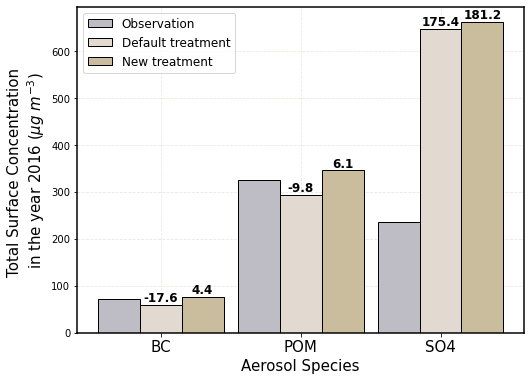

In [164]:
## Compare total surface concentration biases based on monthly means
varbs = ['BC','POM','SO4']
res='RRM'
bc_obs = []
bc_def = []
bc_se = []
for v in varbs:
    df = pd.read_csv(v+'_IMPROVE_dailydata.csv')
    df.index=pd.to_datetime(df['time'])
    df_nona = df[df['obs'].notna()]
    df_nona = df_nona[df_nona['obs']>0]
    df_nona=get_emisMasked(df_nona,res,stat='diff',factor=0.68)
    df_monthly = df_nona.groupby('ncols_'+res).resample('1M').mean()
    df_annual = df_nona.groupby('ncols_'+res).resample('1Y').mean()
    bc_obs.append(df_monthly['obs'].sum())
    bc_def.append(df_monthly[v.lower()+'_RRM'].sum())
    bc_se.append(df_monthly['SE_'+v.lower()+'_RRM'].sum())

barW = 0.3
r1 = np.arange(len(bc_obs))
r2 = [x+barW for x in r1]
r3 = [x+barW for x in r2]

plt.figure(figsize=(8,6))
ax=plt.subplot(111)
plt.bar(r1, bc_obs, width=barW, edgecolor='k', color='#BEBCC5', label='Observation',zorder=2)
plt.bar(r2, bc_def, width=barW, edgecolor='k', color='#E2DAD1', label='Default treatment',zorder=2)
plt.bar(r3, bc_se, width=barW, edgecolor='k', color='#C9BD9E', label='New treatment',zorder=2)
plt.grid(linestyle='--',color='#EBE7E0',zorder=1)
plt.ylabel('Total Surface Concentration \nin the year 2016 ($\u03BCg\ m^{-3}$)',fontsize=15)
plt.xlabel('Aerosol Species',fontsize=15)
plt.legend(fontsize=12)
plt.setp(ax.spines.values(),lw=1.5)
ax.set_xticks([0.3,1.3,2.3])
ax.set_xticklabels(['BC','POM','SO4'],fontsize=15)

## Estimate relative biases
bias_def = np.around(((np.array(bc_def)-np.array(bc_obs))/abs(np.array(bc_obs)))*100,1)
bias_se = np.around(((np.array(bc_se)-np.array(bc_obs))/abs(np.array(bc_obs)))*100,1)
reacts = ax.patches
labels=['','','',str(bias_def[0]),str(bias_def[1]),str(bias_def[2]),str(bias_se[0]),str(bias_se[1]),str(bias_se[2])]

for react,label in zip(reacts,labels):
    height = react.get_height()
    ax.text(react.get_x() + react.get_width()/2,height+1,label,ha="center",va='bottom',size=12,weight='bold')


The bold numbers above the simulated concentration bars indicate the relative bias against the observations. Both BC and POM again show significant relative bias reduction of ~9% and ~12% respectively, when monthly mean data are used. Similar improvement is found even when daily or annual mean data is considred as shown below. With daily data, BC shows ~19% and POM shows ~10% relative bias improvements with the new treatment.

Again, SO4 do not show significant bias corrections. This indicates that other processes driving SO4 concentrations are more important rather than the input emissions.

0.8932794619899266 1.7793017626844343
2.9059262703584694 5.027095356795219
0.0026075429117066724 0.007259487458054354


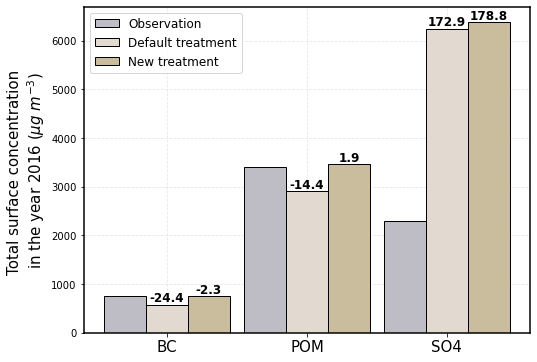

In [165]:
## Compare total surface concentration biases based on daily data
varbs = ['BC','POM','SO4']
res='RRM'
bc_obs = []
bc_def = []
bc_se = []
for v in varbs:
    df = pd.read_csv(v+'_IMPROVE_dailydata.csv')
    df.index=pd.to_datetime(df['time'])
    df_nona = df[df['obs'].notna()]
    df_nona = df_nona[df_nona['obs']>0]
    df_nona=get_emisMasked(df_nona,res,stat='diff',factor=0.68)
    df_monthly = df_nona.groupby('ncols_'+res).resample('1M').mean()
    df_annual = df_nona.groupby('ncols_'+res).resample('1Y').mean()
    bc_obs.append(df_nona['obs'].sum())
    bc_def.append(df_nona[v.lower()+'_RRM'].sum())
    bc_se.append(df_nona['SE_'+v.lower()+'_RRM'].sum())

barW = 0.3
r1 = np.arange(len(bc_obs))
r2 = [x+barW for x in r1]
r3 = [x+barW for x in r2]

plt.figure(figsize=(8,6))
ax=plt.subplot(111)
plt.bar(r1, bc_obs, width=barW, edgecolor='k', color='#BEBCC5', label='Observation',zorder=2)
plt.bar(r2, bc_def, width=barW, edgecolor='k', color='#E2DAD1', label='Default treatment',zorder=2)
plt.bar(r3, bc_se, width=barW, edgecolor='k', color='#C9BD9E', label='New treatment',zorder=2)
plt.grid(linestyle='--',color='#EBE7E0',zorder=1)
plt.ylabel('Total surface concentration \nin the year 2016 ($\u03BCg\ m^{-3}$)',fontsize=15)
plt.legend(fontsize=12)
plt.setp(ax.spines.values(),lw=1.5)
ax.set_xticks([0.3,1.3,2.3])
ax.set_xticklabels(['BC','POM','SO4'],fontsize=15)

## Estimate relative biases
bias_def = np.around(((np.array(bc_def)-np.array(bc_obs))/abs(np.array(bc_obs)))*100,1)
bias_se = np.around(((np.array(bc_se)-np.array(bc_obs))/abs(np.array(bc_obs)))*100,1)
reacts = ax.patches
labels=['','','',str(bias_def[0]),str(bias_def[1]),str(bias_def[2]),str(bias_se[0]),str(bias_se[1]),str(bias_se[2])]

for react,label in zip(reacts,labels):
    height = react.get_height()
    ax.text(react.get_x() + react.get_width()/2,height+1,label,ha="center",va='bottom',size=12,weight='bold')

0.8932794619899266 1.7793017626844343
2.9059262703584694 5.027095356795219
0.0026075429117066724 0.007259487458054354


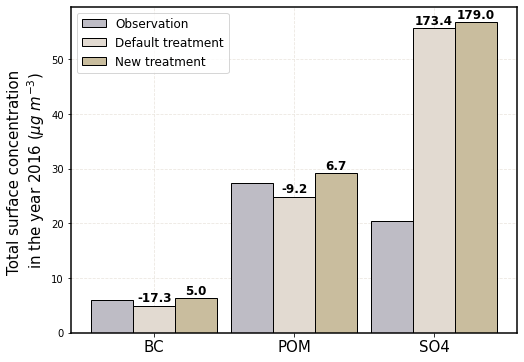

In [166]:
## Compare total surface concentration biases based on annual means
varbs = ['BC','POM','SO4']
res='RRM'
bc_obs = []
bc_def = []
bc_se = []
for v in varbs:
    df = pd.read_csv(v+'_IMPROVE_dailydata.csv')
    df.index=pd.to_datetime(df['time'])
    df_nona = df[df['obs'].notna()]
    df_nona = df_nona[df_nona['obs']>0]
    df_nona=get_emisMasked(df_nona,res,stat='diff',factor=0.68)
    df_monthly = df_nona.groupby('ncols_'+res).resample('1M').mean()
    df_annual = df_nona.groupby('ncols_'+res).resample('1Y').mean()
    bc_obs.append(df_annual['obs'].sum())
    bc_def.append(df_annual[v.lower()+'_RRM'].sum())
    bc_se.append(df_annual['SE_'+v.lower()+'_RRM'].sum())

barW = 0.3
r1 = np.arange(len(bc_obs))
r2 = [x+barW for x in r1]
r3 = [x+barW for x in r2]

plt.figure(figsize=(8,6))
ax=plt.subplot(111)
plt.bar(r1, bc_obs, width=barW, edgecolor='k', color='#BEBCC5', label='Observation',zorder=2)
plt.bar(r2, bc_def, width=barW, edgecolor='k', color='#E2DAD1', label='Default treatment',zorder=2)
plt.bar(r3, bc_se, width=barW, edgecolor='k', color='#C9BD9E', label='New treatment',zorder=2)
plt.grid(linestyle='--',color='#EBE7E0',zorder=1)
plt.ylabel('Total surface concentration \nin the year 2016 ($\u03BCg\ m^{-3}$)',fontsize=15)
plt.legend(fontsize=12)
plt.setp(ax.spines.values(),lw=1.5)
ax.set_xticks([0.3,1.3,2.3])
ax.set_xticklabels(['BC','POM','SO4'],fontsize=15)

## Estimate relative biases
bias_def = np.around(((np.array(bc_def)-np.array(bc_obs))/abs(np.array(bc_obs)))*100,1)
bias_se = np.around(((np.array(bc_se)-np.array(bc_obs))/abs(np.array(bc_obs)))*100,1)
reacts = ax.patches
labels=['','','',str(bias_def[0]),str(bias_def[1]),str(bias_def[2]),str(bias_se[0]),str(bias_se[1]),str(bias_se[2])]

for react,label in zip(reacts,labels):
    height = react.get_height()
    ax.text(react.get_x() + react.get_width()/2,height+0.2,label,ha="center",va='bottom',size=12,weight='bold')

### 10th and 90th percentile plots

Results mostly remain same except the correlations are now statistically significant at 90% confidence interval

1.04345376262937 1.8490149256896862


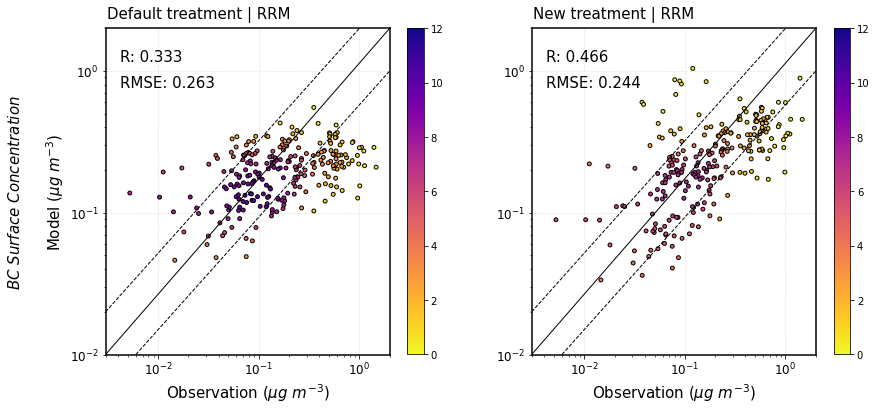

In [167]:
## BC
varbs = ['bc_a1_SRF','SE_bc_a1_SRF','bc_a4_SRF','SE_bc_a4_SRF','bc','SE_bc']
df = pd.read_csv('BC_IMPROVE_dailydata.csv')
variable='BC'
df.index=pd.to_datetime(df['time'])
## Get rid of nans & -ve vals
df_nona = df[df['obs'].notna()]
df_nona = df_nona[df_nona['obs']>0]
res='RRM'
## Masking data based on mean +/- 0.5*Standard deviation
df_nona=get_emisMasked(df_nona,res,stat='diff',factor=0.81)
## Estimating the monthly and annual averages from daily data
df_monthly = df_nona.groupby('ncols_'+res).resample('1M').mean()
df_annual = df_nona.groupby('ncols_'+res).resample('1Y').mean()
## Plotting
plt.figure(figsize=(14,6))
i=1
for v,treat,ylab in zip(varbs[-2:],['Default','New'],['$'+variable+'\ Surface\ Concentration$ \n\nModel ($\u03BCg\ m^{-3}$)','']):
    ax=plt.subplot(1,2,i)
    get_scatter_plot(df_monthly,v,res,ax,treatment=treat,temp='monthly',size=15,cax=[3e-3,1e-2,2e0,2e0],maxv=12,vv=ylab)
    i+=1


3.5207860338876107 5.078235011054572


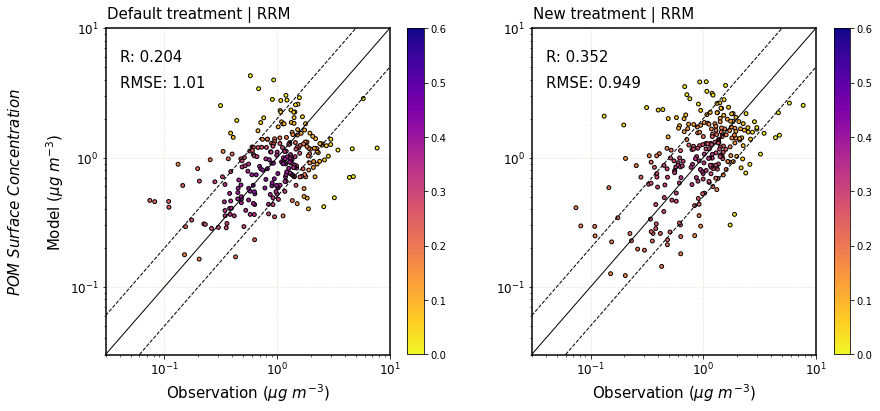

In [170]:
## POM
varbs = ['pom_a1_SRF','SE_pom_a1_SRF','pom_a4_SRF','SE_pom_a4_SRF','pom','SE_pom']
df = pd.read_csv('POM_IMPROVE_dailydata.csv')
variable='POM'
df.index=pd.to_datetime(df['time'])
## Get rid of nans & -ve vals
df_nona = df[df['obs'].notna()]
df_nona = df_nona[df_nona['obs']>0]
res='RRM'
## Masking data based on mean +/- 0.5*Standard deviation
df_nona=get_emisMasked(df_nona,res,stat='diff',factor=0.81)
## Estimating the monthly and annual averages from daily data
df_monthly = df_nona.groupby('ncols_'+res).resample('1M').mean()
df_annual = df_nona.groupby('ncols_'+res).resample('1Y').mean()
## Plotting
plt.figure(figsize=(14,6))
i=1
for v,treat,ylab in zip(varbs[-2:],['Default','New'],['$'+variable+'\ Surface\ Concentration$ \n\nModel ($\u03BCg\ m^{-3}$)','']):
    ax=plt.subplot(1,2,i)
    get_scatter_plot(df_monthly,v,res,ax,treatment=treat,temp='monthly',size=15,cax=[3e-2,3e-2,1e1,1e1],maxv=0.6,vv=ylab)
    i+=1


0.003213941188641719 0.0076596615947993035


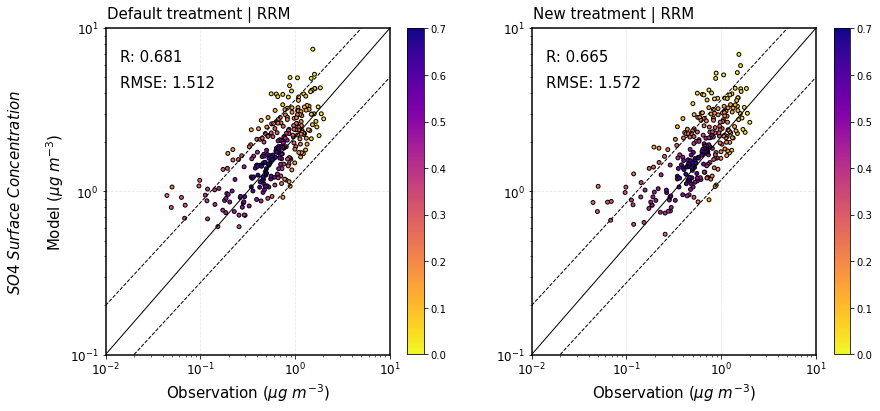

In [171]:
## SO4
varbs = ['so4_a1_SRF','SE_so4_a1_SRF','so4_a2_SRF','SE_so4_a2_SRF','so4','SE_so4']
df = pd.read_csv('SO4_IMPROVE_dailydata.csv')
variable='SO4'
df.index=pd.to_datetime(df['time'])
## Get rid of nans & -ve vals
df_nona = df[df['obs'].notna()]
df_nona = df_nona[df_nona['obs']>0]
res='RRM'
## Masking data based on mean +/- 0.5*Standard deviation
df_nona=get_emisMasked(df_nona,res,stat='diff',factor=0.81)
## Estimating the monthly and annual averages from daily data
df_monthly = df_nona.groupby('ncols_'+res).resample('1M').mean()
df_annual = df_nona.groupby('ncols_'+res).resample('1Y').mean()
## Plotting
plt.figure(figsize=(14,6))
i=1
for v,treat,ylab in zip(varbs[-2:],['Default','New'],['$'+variable+'\ Surface\ Concentration$ \n\nModel ($\u03BCg\ m^{-3}$)','']):
    ax=plt.subplot(1,2,i)
    get_scatter_plot(df_monthly,v,res,ax,treatment=treat,temp='monthly',size=15,maxv=0.7,vv=ylab)
    i+=1


### Compare total surface concentration biases beyond 10 or 90th percentile

1.04345376262937 1.8490149256896862
3.5207860338876107 5.078235011054572
0.003213941188641719 0.0076596615947993035


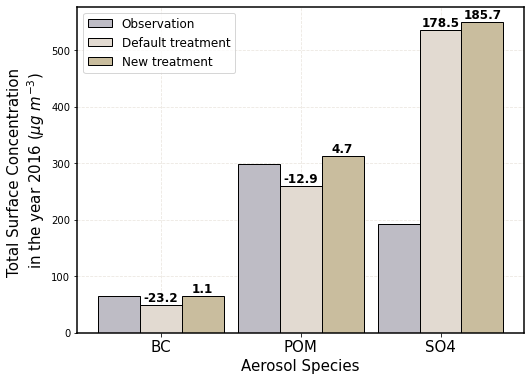

In [172]:
varbs = ['BC','POM','SO4']
res='RRM'
bc_obs = []
bc_def = []
bc_se = []
for v in varbs:
    df = pd.read_csv(v+'_IMPROVE_dailydata.csv')
    df.index=pd.to_datetime(df['time'])
    df_nona = df[df['obs'].notna()]
    df_nona = df_nona[df_nona['obs']>0]
    df_nona=get_emisMasked(df_nona,res,stat='diff',factor=0.81)
    df_monthly = df_nona.groupby('ncols_'+res).resample('1M').mean()
    df_annual = df_nona.groupby('ncols_'+res).resample('1Y').mean()
    bc_obs.append(df_monthly['obs'].sum())
    bc_def.append(df_monthly[v.lower()+'_RRM'].sum())
    bc_se.append(df_monthly['SE_'+v.lower()+'_RRM'].sum())

barW = 0.3
r1 = np.arange(len(bc_obs))
r2 = [x+barW for x in r1]
r3 = [x+barW for x in r2]

plt.figure(figsize=(8,6))
ax=plt.subplot(111)
plt.bar(r1, bc_obs, width=barW, edgecolor='k', color='#BEBCC5', label='Observation',zorder=2)
plt.bar(r2, bc_def, width=barW, edgecolor='k', color='#E2DAD1', label='Default treatment',zorder=2)
plt.bar(r3, bc_se, width=barW, edgecolor='k', color='#C9BD9E', label='New treatment',zorder=2)
plt.grid(linestyle='--',color='#EBE7E0',zorder=1)
plt.ylabel('Total Surface Concentration \nin the year 2016 ($\u03BCg\ m^{-3}$)',fontsize=15)
plt.xlabel('Aerosol Species',fontsize=15)
plt.legend(fontsize=12)
plt.setp(ax.spines.values(),lw=1.5)
ax.set_xticks([0.3,1.3,2.3])
ax.set_xticklabels(['BC','POM','SO4'],fontsize=15)

## Estimate relative biases
bias_def = np.around(((np.array(bc_def)-np.array(bc_obs))/abs(np.array(bc_obs)))*100,1)
bias_se = np.around(((np.array(bc_se)-np.array(bc_obs))/abs(np.array(bc_obs)))*100,1)
reacts = ax.patches
labels=['','','',str(bias_def[0]),str(bias_def[1]),str(bias_def[2]),str(bias_se[0]),str(bias_se[1]),str(bias_se[2])]

for react,label in zip(reacts,labels):
    height = react.get_height()
    ax.text(react.get_x() + react.get_width()/2,height+1,label,ha="center",va='bottom',size=12,weight='bold')
